# Table of Contents
* [Set up environment](#env)
* [Read in Data](#load)
* [Univariate Analysis and Sanity Check](#uni)
    * [Treat Missing Values](#miss)
* [Comparing Two Proportions](#proportion)
    * [Self-defined Calculation](#self)
    * [Using Scipy Package](#sci) 
* [Experiment Sanity Check](#san)
    * [Conversion Rate over Time](#ot)
    * [Underlined Distribution of Other Attributes](#dis)
* [Self-designed Algorithm Checking Randomization](#rand)

# Set up Environment
<a id="env"></a> 

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import warnings
warnings.simplefilter('default')
from scipy import stats

# Read in Data
<a id="load"></a> 

In [2]:
# read in test_table
test_df = pd.read_csv("./Translation_Test/test_table.csv")
test_df.shape

(453321, 9)

In [3]:
# read in user_table
user_df = pd.read_csv("./Translation_Test/user_table.csv")
user_df.shape

(452867, 4)

In [4]:
test_df.shape[0]-user_df.shape[0]

454

In [5]:
## any duplicates of the user_id in two data sets
print(len(test_df.user_id.unique()) == test_df.shape[0])
print(len(user_df.user_id.unique()) == user_df.shape[0])

True
True


There is no duplicates of user_id in two data sets and there is 454 users that exist in the test_table but not in user_table. In the next table merge step, I used the left join.

In [6]:
# merge two tables
df = test_df.merge(user_df, on="user_id", how = "left")
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [7]:
df.shape

(453321, 12)

In [8]:
df.dtypes

user_id               int64
date                 object
source               object
device               object
browser_language     object
ads_channel          object
browser              object
conversion            int64
test                  int64
sex                  object
age                 float64
country              object
dtype: object

# Univariate Analysis and Sanity Check 
<a id="uni"> </a>

In [9]:
# check na in the df
df.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

In [10]:
df.describe(include="all")

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000,452867,452867.000000,452867
unique,NaN,5,3,2,3,5,7,NaN,NaN,2,NaN,17
top,NaN,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN,M,NaN,Mexico
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN,264485,NaN,128484
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446,NaN,27.130740,NaN
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445,NaN,6.776678,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,18.000000,NaN
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,22.000000,NaN
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,26.000000,NaN
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,31.000000,NaN


Couple Observations of the data:

* NA in variable 'ads_channel' means the user is not coming from ads, so we can mark the NA as a new value 'Direct'. The new value 'Direct' means the user is direct visit.
* The NA observations in 'sex', 'age' and 'country' variables are caused by the missing user_id in the user_table.

In [11]:
# verify the hypothesis: NaN in 'sex','age','country' as systematic missing
count = 0
for i in range(df.shape[0]):
    if pd.isnull(df['sex'][i]) and pd.isnull(df['age'][i]) and pd.isnull(df['country'][i]):
        count=count + 1
print("missing rate of sex, age, country is %0.4f"%(1.00*count/df.shape[0]))

missing rate of sex, age, country is 0.0010


NaN in 'sex','age','country' is systematic missing, but the missing pattern is not correlated to the other variables as shown below. The missing rate is 0.1%, so directly deleting 

In [12]:
# check the reason for missing
df[pd.isnull(df['sex'])==True].date.unique()

array(['2015-12-02', '2015-12-04', '2015-12-01', '2015-11-30',
       '2015-12-03'], dtype=object)

In [13]:
# check the reason for missing
df[pd.isnull(df['sex'])==True].source.unique()

array(['Ads', 'Direct', 'SEO'], dtype=object)

In [14]:
df[pd.isnull(df['sex'])==True].device.unique()

array(['Mobile', 'Web'], dtype=object)

In [15]:
df[pd.isnull(df['sex'])==True].browser_language.unique()

array(['ES', 'EN', 'Other'], dtype=object)

In [16]:
df[pd.isnull(df['sex'])==True].ads_channel.unique()

array(['Bing', nan, 'Yahoo', 'Facebook', 'Google', 'Other'], dtype=object)

In [17]:
df[pd.isnull(df['sex'])==True].browser.unique()

array(['Android_App', 'Chrome', 'IE', 'Safari', 'Iphone_App', 'FireFox',
       'Opera'], dtype=object)

In [18]:
df[pd.isnull(df['sex'])==True].conversion.unique()

array([0, 1])

In [19]:
df[pd.isnull(df['sex'])==True].test.unique()

array([0, 1])

## Treat Missing Values
<a id="miss"> </a>

In [20]:
df.ads_channel[df.ads_channel.isna()==True] = 'Direct'
df.ads_channel.unique()

/Applications/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array(['Direct', 'Google', 'Facebook', 'Bing', 'Yahoo', 'Other'],
      dtype=object)

In [21]:
df = df.dropna()

In [22]:
df.shape

(452867, 12)

# Comparing Two Proportions
<a id="proportion"> </a>

In [23]:
control = df[df.test==0]
test = df[df.test==1]

## Self-defined Calculation
<a id="self"> </a>
https://onlinecourses.science.psu.edu/stat414/node/268/

Two sample t-test of proportion:
control: group 0; test: group 1
X: representing convert or not of each user, 0/1
X0 ~ Bernoulli(p0); X1 ~ Bernoulli(p1)
Y0 = X01+...+X0n0 ; Y1 = X11+...+X1n1

H0: p0=p1
Ha: p0^=p1

Based on CLT:
p0 = bar(X0) ~N(u0,sigma_0^2/n0)
p1 = bar(X1) ~N(u1,sigma_1^2/n1)

The above u can be estimated by the sample mean of X and the sigma can be estimated by the sample standard deviation of X since they are unknown parameters.

Here, bar(X0) and var(X1) are two random variables from two independent normal distributions and the variance of these two R.V. are unkonwn, so the t-test should be conducted here.

Theorem: The test statistic for testing the difference in two population proportions, that is, for testing the null hypothesis
H0:p1−p2=0
is:

Z=(p̂0−p̂1)−0/[√p̂(1−p̂)(1/n0+1/n1)]

where:

p̂=(Y0+Y1)/n0+n1
the proportion of "successes" in the two samples combined.


In [24]:
from numpy import sqrt, abs, round
from scipy.stats import norm
n0 = control.shape[0]
n1 = test.shape[0]
p0 = 1.0*df[df.test==0].conversion.sum()/df[df.test==0].shape[0]
p1 = 1.0*df[df.test==1].conversion.sum()/df[df.test==1].shape[0]
p = 1.0*(df[df.test==0].conversion.sum()+df[df.test==1].conversion.sum())/(df[df.test==0].shape[0]+df[df.test==1].shape[0])
N = 1.0/n0 + 1.0/n1
Z = 1.0*(p0-p1)/(1.0*p*(1-p)*N)**0.5
pval = 2*(1 - 1.0*norm.cdf(abs(Z), loc=0, scale=1))
print('{0:0.8f}'.format(pval), '{0:0.2f}'.format(Z))

('0.00000000', '18.19')


## Using Scipy Package
<a id="sci"> </a>

In [25]:
data = pd.DataFrame({
    "Converted": [df[df.test==0].conversion.sum(), df[df.test==1].conversion.sum()],
    "Total": [df[df.test==0].shape[0], df[df.test==1].shape[0]]
    }, index=['Control', 'Var'])

from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(count=data.Converted, nobs=data.Total, alternative='two-sided')
print('{0:0.8f}'.format(pval),'{0:0.2f}'.format(stat))

('0.00000000', '18.19')


* The results from self-defined and scipy.stats package are the same.
* Here comes the conclusion for the test: From the test result, compared to the localized translation, the old version of the site with just one translation across Spain and LatAm performs better.

# Experiment Sanity Check
<a id="san"> </a>

The experiment sanity check is conducted to address the following questions:
1. Was the conversion rate trend normal for both ctrl and exp groups?
2. Was the underlined distribution of other attributes the same in both ctrl and exp groups?
3. If underlined distribution of some attributes are not the same by plotting, does the difference also exist statistically?

## Conversion Rate over Time
<a id="ot"> </a>

In [26]:
df['date'] = pd.to_datetime(df['date'])

In [27]:
#conv_ct = df.groupby(['date','test']).aggregate({"conversion":{"conv_ct":"sum"}}).unstack()
#total_ct = df.groupby(['date','test']).aggregate({"conversion":{"total_ct":"count"}}).unstack()
#conv_ct = df.groupby(['date','test']).conversion.apply(lambda x: sum(x))
#conv_ct = df.groupby(['date','test']).conversion.sum()
#total_ct = df.groupby(['date','test']).conversion.count()
#conv_rt = round(conv_ct/total_ct,4)
#conv_ct = df.groupby(['date','test']).conversion.mean()

# pipe function
#conv_ct = df.groupby(['date','test']).pipe(lambda grp: grp.conversion.sum()/grp.conversion.count()).unstack().round(3)
#conv_ct = pd.melt(conv_ct.reset_index(), id_vars=conv_ct.index.name, value_vars=list(conv_ct.columns.values), 
                  #var_name='test', value_name='conv_rt').sort_values(by=['date','test'])
#conv_ct

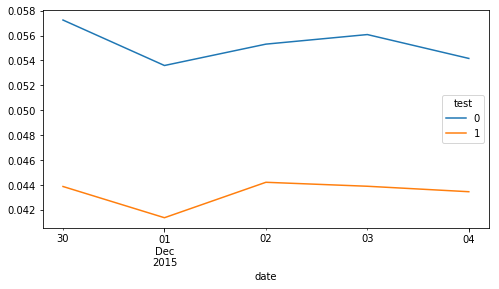

In [28]:
 #ax = sns.lineplot(data=conv_ct)
# plot data
fig, ax = plt.subplots(figsize=(8,4))
# use unstack()
df.groupby(['date','test']).mean()['conversion'].unstack().plot(ax=ax)

* The conversion rate on 01Dec 2015 is lower than the other four dates, which is abnormal in the data set. The data science team need to investigate the data on this specific date.
* We only ran the experiment for five days. We might need to run a full week to cover all the weekends and weekdays.

## Underlined Distribution of Other Attributes
<a id="dis"> </a>

In [29]:
def Bivariate_freq_plot(df, var1, var2, label):
    grouped = df[[var1, var2, label]].groupby([var1, var2]).mean().reset_index()
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    sns.countplot(x = var1, hue = var2, data = df, ax = ax[0])
    ax[0].set_title('Count Plot of ' + var1, fontsize = 16)
    ax[0].set_yscale('log')
    sns.barplot(x = var1, hue = var2, y = label, data = df, ax = ax[1]);
    ax[1].set_title('Mean Conversion Rate per ' + var1, fontsize = 16)
    plt.tight_layout()
    plt.show()
    return grouped

/Applications/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


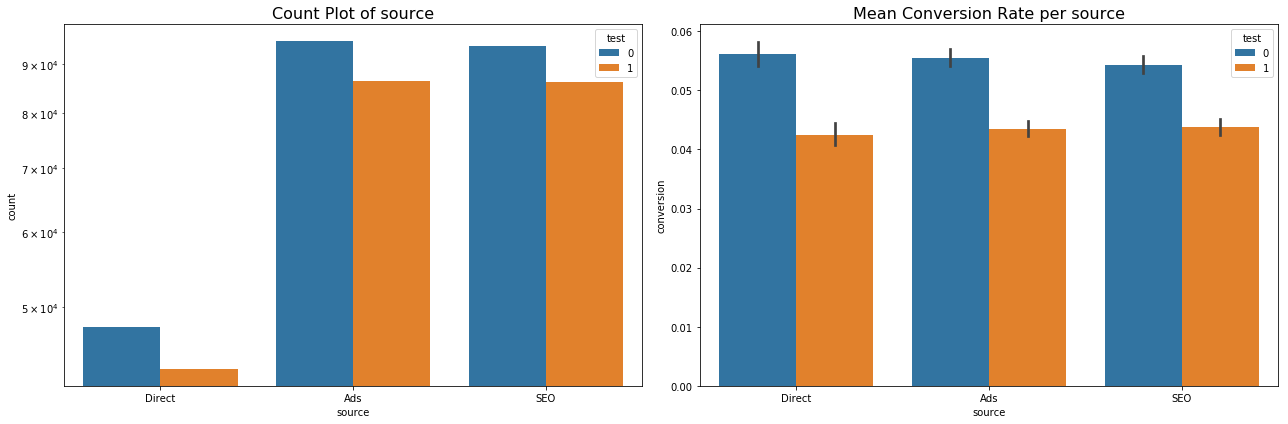

,source,test,conversion
0,Ads,0,0.055436
1,Ads,1,0.043529
2,Direct,0,0.056195
3,Direct,1,0.042512
4,SEO,0,0.054345
5,SEO,1,0.043742


In [30]:
Bivariate_freq_plot(df = df, var1 = 'source', var2 = 'test', label = 'conversion')

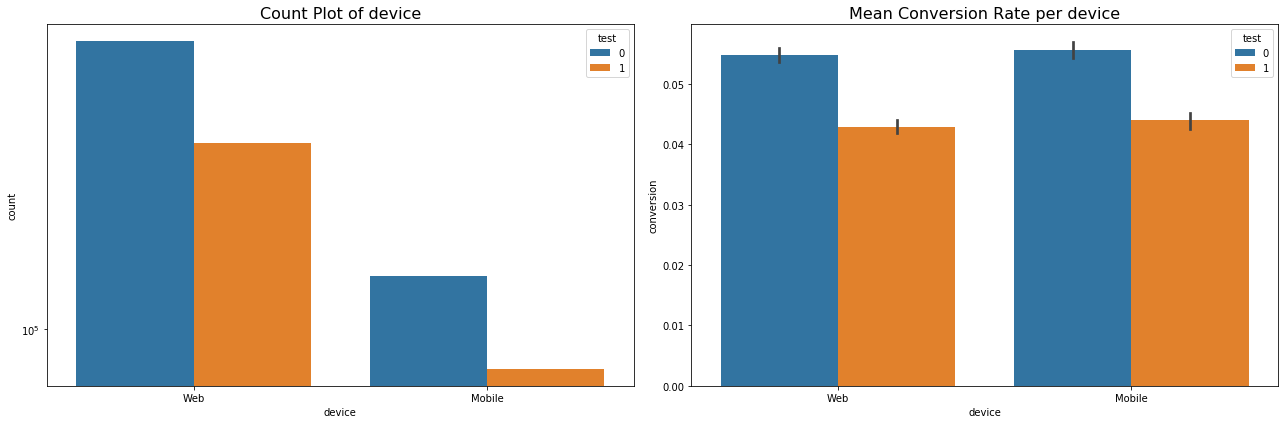

,device,test,conversion
0,Mobile,0,0.055663
1,Mobile,1,0.044008
2,Web,0,0.054750
3,Web,1,0.042931


In [31]:
Bivariate_freq_plot(df = df, var1 = 'device', var2 = 'test', label = 'conversion')

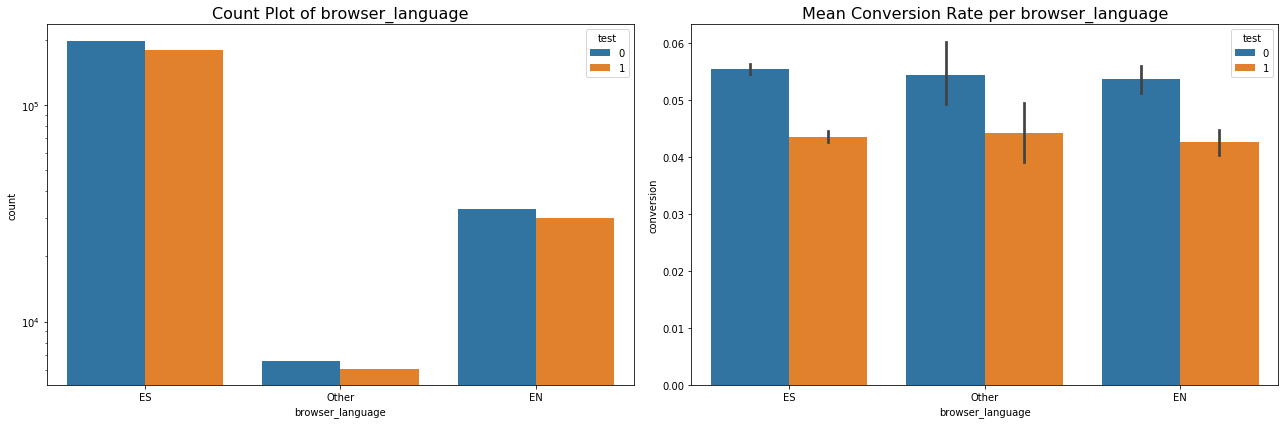

,browser_language,test,conversion
0,EN,0,0.053650
1,EN,1,0.042616
2,ES,0,0.055431
3,ES,1,0.043519
4,Other,0,0.054437
5,Other,1,0.044152


In [32]:
Bivariate_freq_plot(df = df, var1 = 'browser_language', var2 = 'test', label = 'conversion')

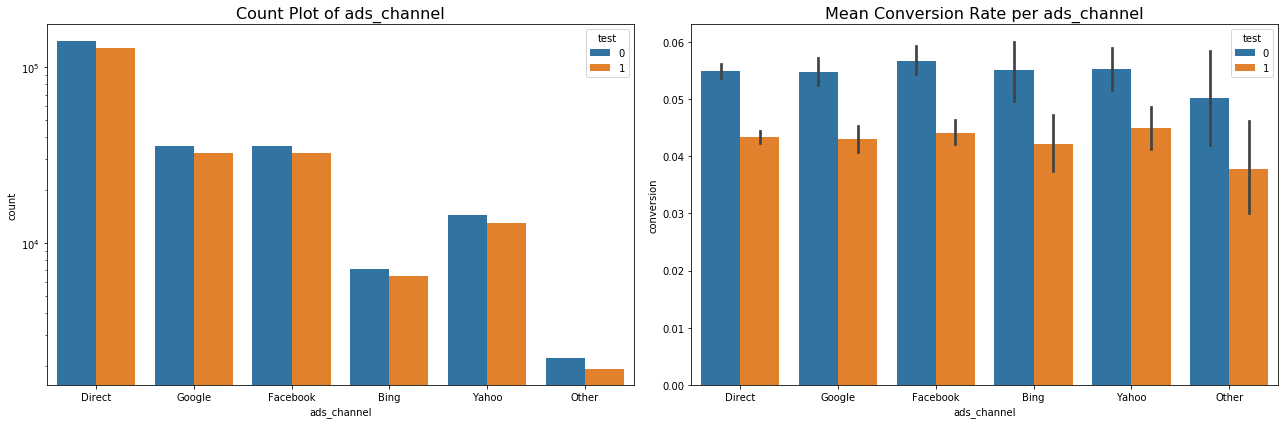

,ads_channel,test,conversion
0,Bing,0,0.055013
1,Bing,1,0.042102
2,Direct,0,0.054967
3,Direct,1,0.043332
4,Facebook,0,0.056698
5,Facebook,1,0.044132
6,Google,0,0.054680
7,Google,1,0.042992
8,Other,0,0.050158
9,Other,1,0.037824


In [33]:
Bivariate_freq_plot(df = df, var1 = 'ads_channel', var2 = 'test', label = 'conversion')

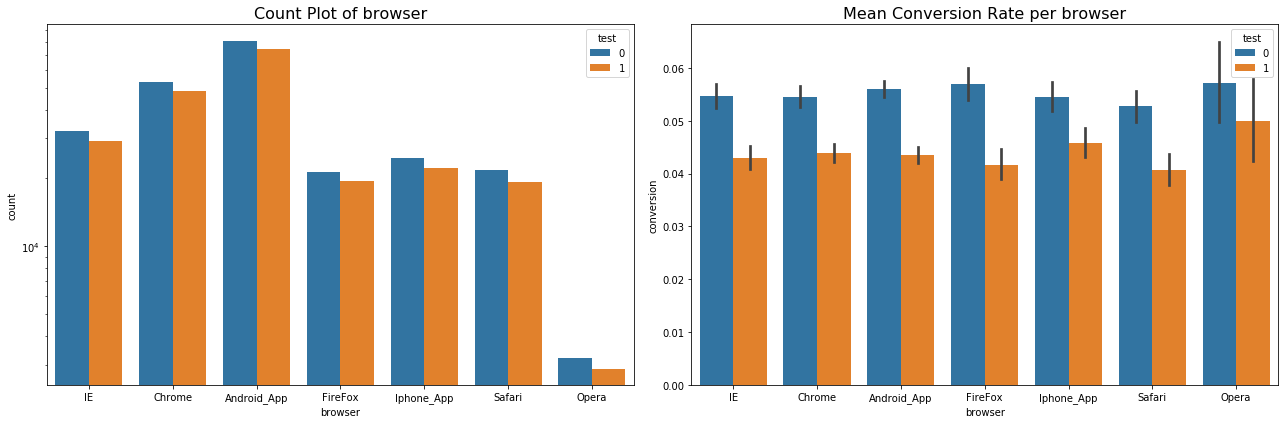

,browser,test,conversion
0,Android_App,0,0.056016
1,Android_App,1,0.043464
2,Chrome,0,0.054573
3,Chrome,1,0.043831
4,FireFox,0,0.056970
5,FireFox,1,0.041634
6,IE,0,0.054658
7,IE,1,0.043021
8,Iphone_App,0,0.054493
9,Iphone_App,1,0.045826


In [34]:
Bivariate_freq_plot(df = df, var1 = 'browser', var2 = 'test', label = 'conversion')

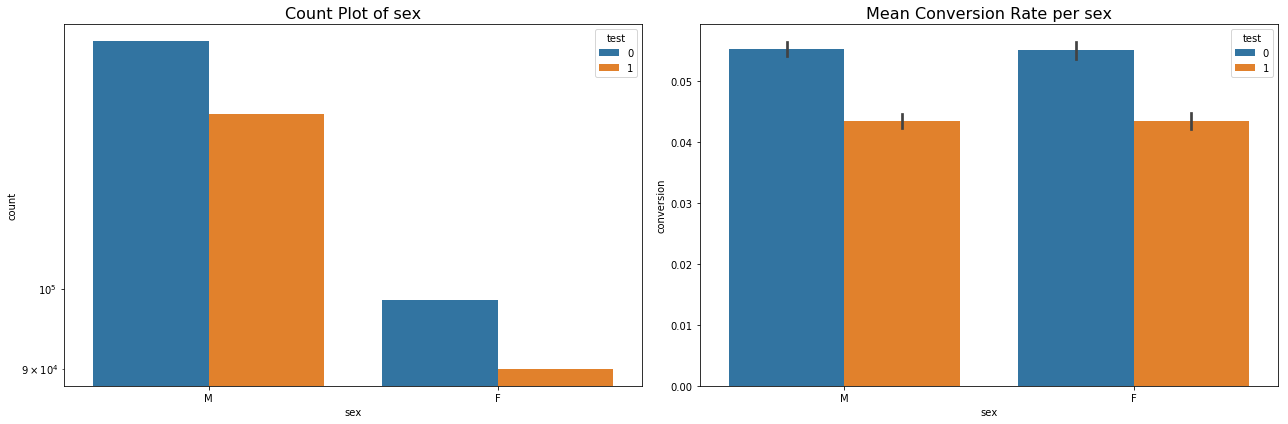

,sex,test,conversion
0,F,0,0.054990
1,F,1,0.043377
2,M,0,0.055273
3,M,1,0.043435


In [35]:
Bivariate_freq_plot(df = df, var1 = 'sex', var2 = 'test', label = 'conversion')

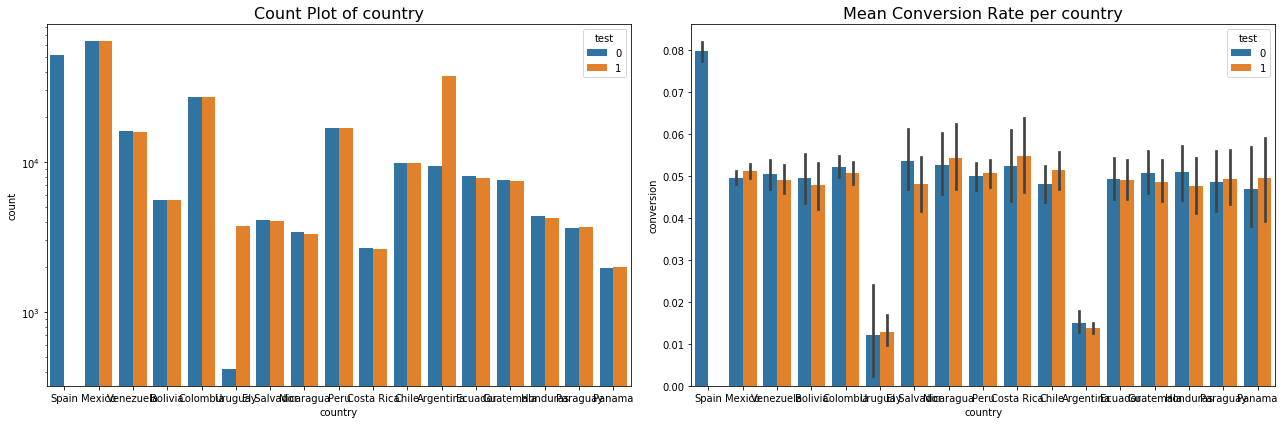

,country,test,conversion
0,Argentina,0,0.015071
1,Argentina,1,0.013725
2,Bolivia,0,0.049369
3,Bolivia,1,0.047901
4,Chile,0,0.048107
5,Chile,1,0.051295
6,Colombia,0,0.052089
7,Colombia,1,0.050571
8,Costa Rica,0,0.052256
9,Costa Rica,1,0.054738


In [36]:
Bivariate_freq_plot(df = df, var1 = 'country', var2 = 'test', label = 'conversion')

One Important Finding:

There is something run when splitting the control and experiment traffic when conducting A/B testing. From the above plot, there is no Spain users in the experiment group, and much more Paraguay and Agentina users in the experiment group. Given the conversion rate of Spain is much higher than rest of the regions and the conversion rate in Paraguay and Agentina is much lower than the rest of the world, the reason that the overall conversion rate in testing group is statistically lower than the control group is not only because of the translation version difference. The biased the traffic spliting algorithm counts for the lower conversion rate in the testing group.

* Next step:
Test if there is significant different in the age between the ctrl and exp group (unpaired two sample t-test)

In [37]:
import math
from scipy.stats import t
def t_test_cal_pvalue(s1, s2):
    mean1 = s1.mean()
    mean2 = s2.mean()
    std1 = s1.std()
    std2 = s2.std()
    nm = pow(pow(std1,2)/len(s1) + pow(std2,2)/len(s2), 2)
    dn = pow(pow(std1,2)/len(s1), 2)/(len(s1)-1) + pow(pow(std2,2)/len(s2), 2)/(len(s2)-1)
    dgf = math.floor(nm/dn)
    stat = (mean1-mean2) / math.sqrt(pow(std1,2)/len(s1) + pow(std2,2)/len(s2))
    pvalue = 2*(1-t.cdf(abs(stat), dgf))
    return pvalue
t_test_cal_pvalue(df[df.test==0].age, df[df.test==1].age) #0.1418225138378133

0.1418225138378133

Suggestions: 

* The reason that the overall conversion rate in testing group is statistically lower than the control group is not only because of the translation version difference. The biased traffic splitting by country is might be the reason. Based on the above analysis, we can not simply draw the conclusion that the localized translation is worse. We need to redo the randomization for the experiment.

* We only ran the experiment for five days. We might need to run a full week to cover all the weekends and weekdays.


# Self-designed Algorithm Checking Randomization
<a id="rand"> </a>

In an ideal world, the distribution of people in test and control for each segment should be the same. There are many ways to detect this. One way is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well). In the real world work, people usually use propensity score matching to randomize traffic in A/B testing.

In the following algorithm, the function returns True if it's a randomized experiment, and it returns False verse vesa.

In [38]:
# One hot encoding
X = df[df.columns.difference(['conversion','test','date','user_id'])]
age = X.age
X_cat = X[X.columns.difference(['age'])]
X_d = pd.get_dummies(data = X_cat)
X = pd.concat([X_d,age],axis = 1)
Y = df.test

In [39]:
# Build a Classification Tree
from sklearn import tree
from sklearn.tree import export_graphviz
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, Y)

In [40]:
# Visualize the Tree Structure
from sklearn.tree import export_graphviz
import pydot
# Save the tree as a png image
export_graphviz(clf, out_file = 'decision_tree.dot', feature_names = X.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('decision_tree.dot')
graph.write_png('decision_tree.png');

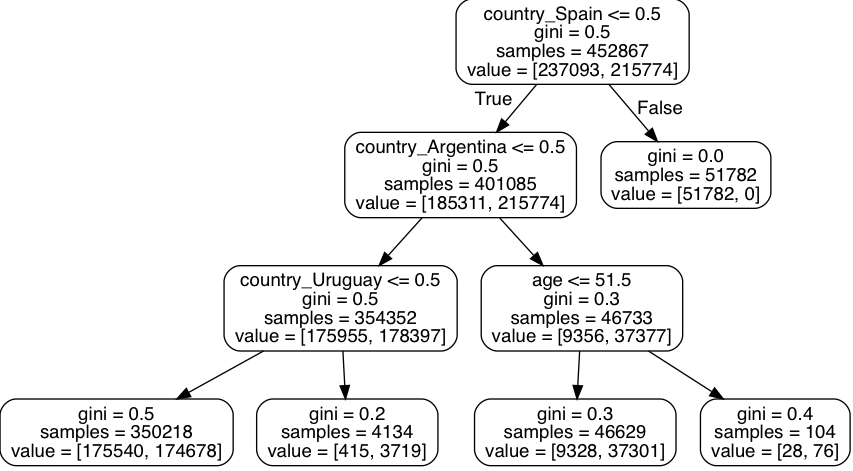

In [41]:
# Plot the Variable Importance list
feature_names = X.columns
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

['Variable: country_Spain        Importance: 0.76',
 'Variable: country_Argentina    Importance: 0.21',
 'Variable: country_Uruguay      Importance: 0.04',
 'Variable: ads_channel_Bing     Importance: 0.0',
 'Variable: ads_channel_Direct   Importance: 0.0',
 'Variable: ads_channel_Facebook Importance: 0.0',
 'Variable: ads_channel_Google   Importance: 0.0',
 'Variable: ads_channel_Other    Importance: 0.0',
 'Variable: ads_channel_Yahoo    Importance: 0.0',
 'Variable: browser_Android_App  Importance: 0.0',
 'Variable: browser_Chrome       Importance: 0.0',
 'Variable: browser_FireFox      Importance: 0.0',
 'Variable: browser_IE           Importance: 0.0',
 'Variable: browser_Iphone_App   Importance: 0.0',
 'Variable: browser_Opera        Importance: 0.0',
 'Variable: browser_Safari       Importance: 0.0',
 'Variable: browser_language_EN  Importance: 0.0',
 'Variable: browser_language_ES  Importance: 0.0',
 'Variable: browser_language_Other Importance: 0.0',
 'Variable: country_Bolivi

Conclusion:

* It is not surprising that country_Spain, country_Argentina and country_Uruguay are the top 3 most important variables that split in this decision tree. From the decision tree, in the root node, if the user is from Spain (country_Spain > 0.5), the user would be fully assigned to the right child node, which is control group. This result is consistent with my experiment sanity check result. 
* The decision did split so the experiment is not fully randomized. The suggestion here is to re-randomize the experiment on attribute "country".